# Chapter 6: More Applications of Image Feature Extraction  

## Problems

1. **Panorama** with `opencv-python`  
 1.1 Image Stitching     
 1.2 Video Stitching
2. Non-negative Matrix Factorization (**NMF**) to extract face features with `nimfa`
3. **Face Recognition** using **LBPH** features with `opencv-python`
4. Face Feature Extraction and Recognition with Gabor Filter Banks  
 4.1 Feature Extraction with **Gabor Filter Bank**     
 4.2 Face Recognition with Gabor Features
5. **Pedestrian detection** with **HOG** vs **HAAR Cascade** features with `opencv-python`     
 5.1 Pedestrian detection with **HOG** **NMS**     
 5.2: **HAAR Cascade** vs. **HOG SVM**

## 1. Panorama with `opencv-python`

## 1.1 Image Stitching

3.4.2
loading images...
Number of images to stitch: 11


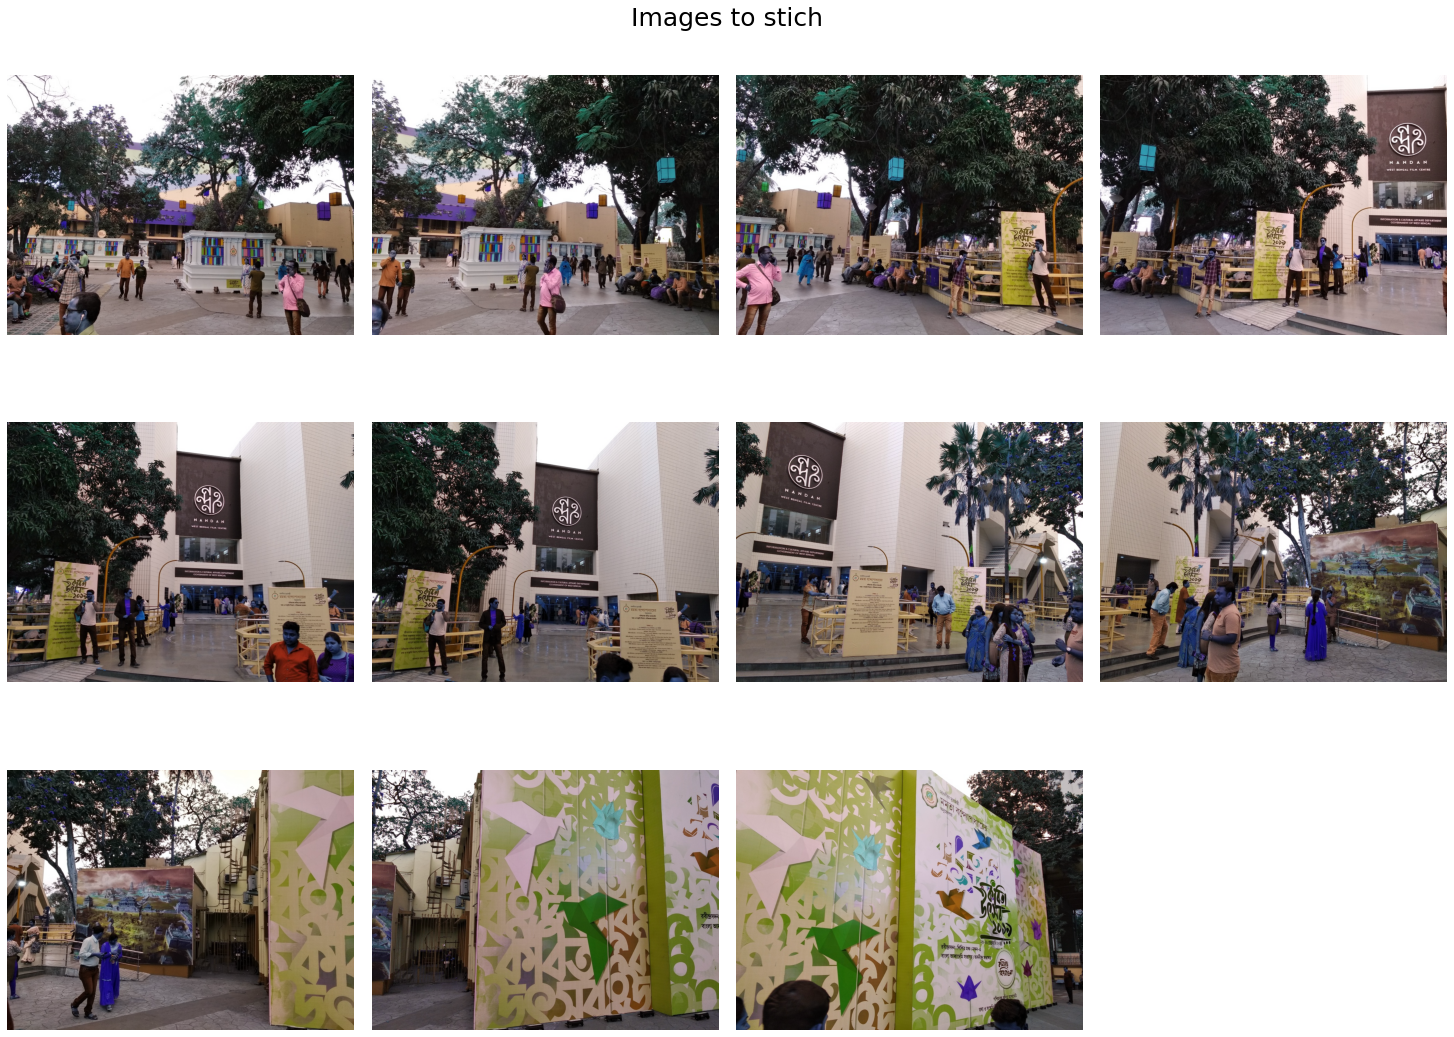

stitching images...
status: 0


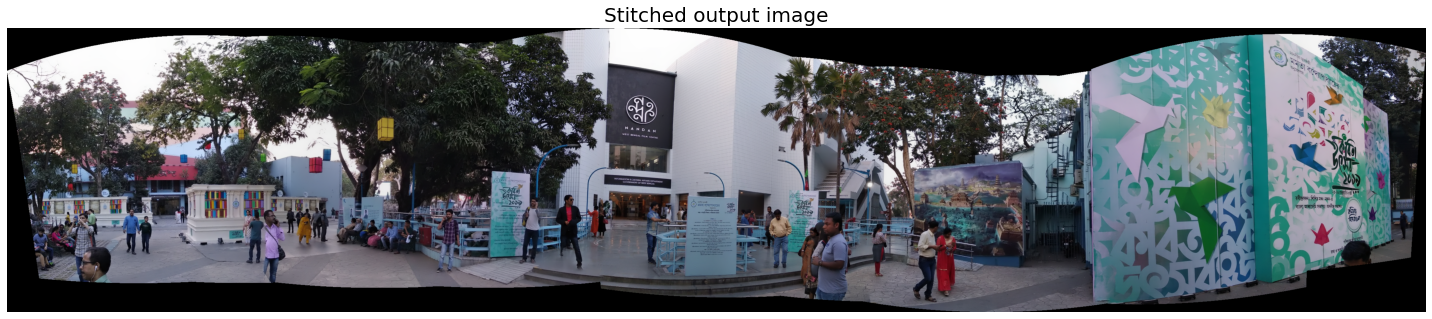

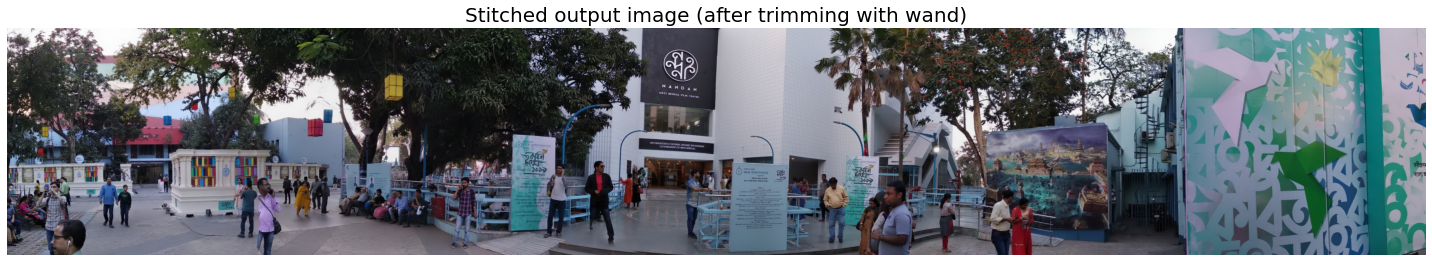

In [151]:
import numpy as np
import cv2
from wand.image import Image
from wand.color import Color
import glob
import matplotlib.pylab as plt

print(cv2.__version__)
# 3.4.2

# grab the paths to the input images and initialize our images list
print("loading images...")
images = [cv2.imread(img) for img in glob.glob('images/pan_*')]
print('Number of images to stitch: {}'.format(len(images)))
fig = plt.figure(figsize=(20, 15))
for i in range(len(images)):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    plt.axis('off')
    
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05) 
plt.suptitle('Images to stich', size=25)

plt.show()

# initialize OpenCV's image sticher object and then perform the image
# stitching
print("stitching images...")
stitcher = cv2.createStitcher()
(status, stitched) = stitcher.stitch(images)

print(f'status: {status}')


# if the status is '0', then OpenCV successfully performed image stitching
if status == 0:
    
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Stitched output image', size=20)
    plt.tight_layout()
    plt.show()
    
    stitched = Image.from_array(stitched)
    stitched.trim(color=Color('rgb(0,0,0)'), percent_background=0.0, fuzz=0)
    stitched = np.array(stitched)
        
    # write the output stitched image to disk
    cv2.imwrite('images/output_panorama.jpg', stitched)
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Stitched output image (after trimming with wand)', size=20)
    plt.tight_layout()
    plt.show()
else: # otherwise the stitching failed, likely due to not enough keypoints being detected)
    print("image stitching failed ({})".format(status))

## 1.2 Video Stitching

In [ ]:
import numpy as np
import datetime
import imutils
import time
import cv2
import imageio

stitcher = cv2.Stitcher_create()
total = 0

reader1 = imageio.get_reader('images/vid1.mp4')
reader2 = imageio.get_reader('images/vid2.mp4')
fps1 = reader1.get_meta_data()['fps']
fps2 = reader2.get_meta_data()['fps']
# print(fps1, fps2)
# assert(fps1 == fps2)

writer = imageio.get_writer('images/vid_stitched.mp4', fps = fps1)

# there are total 602 frames in each of the videos, it will take some time to stitch the videos, wait until finished
for i, (left, right) in enumerate(zip(reader1, reader2)):
    # print(i)
    # resize the frames
    left = imutils.resize(left, width=400)
    right = imutils.resize(right, width=400)
    # print(left.shape, right.shape)

    # stitch the frames together to form the panorama
    (status, result) = stitcher.stitch([left, right])
    # print(i, status)
    
    if status: continue

    # no homograpy could be computed
    if result is None:
        print("[INFO] homography could not be computed")
        break

    writer.append_data(cv2.resize(result, (800, 600)))
    
    #plt.figure(figsize=(20,8))
    #plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    #plt.subplot(131), plt.imshow(left, aspect='auto'), plt.axis('off'), plt.title('Left Frame', size=20) #cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
    #plt.subplot(132), plt.imshow(right, aspect='auto'), plt.axis('off'), plt.title('Right Frame', size=20) #cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
    #plt.subplot(133), plt.imshow(result, aspect='auto'), plt.axis('off'), plt.title('Stitched Frame', size=20) #cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    #plt.savefig('out_{:03d}.png'.format(i))
    #plt.close()
    
writer.close()

![](images/out_143.png)
![](images/out_212.png)
![](images/out_381.png)
![](images/out_599.png)

## 2. Non-negative Matrix Factorization (NMF) to extract Face Features with `nimfa`

In [20]:
from os.path import dirname, abspath
from os.path import join
from warnings import warn

import numpy as np
import nimfa
from matplotlib.pyplot import savefig, imshow, set_cmap, show, axis, figure, subplot
from PIL.Image import open, fromarray, new
from PIL.ImageOps import expand

In [22]:
print("Reading CBCL faces database")
# http://cbcl.mit.edu/software-datasets/FaceData2.html
# http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz : works
dir = join('faces', 'train', 'face')
V = np.zeros((19 * 19, 2429))
for image in range(2429):
    im = open(join(dir, "face0%s.pgm" % str(image + 1).zfill(4)))
    V[:, image] = np.asarray(im).flatten()

Reading CBCL faces database


In [23]:
print("Data preprocessing")
V = (V - V.mean()) / np.sqrt(np.multiply(V, V).mean())
V = np.maximum(np.minimum((V + 0.25) * 0.25, 1), 0)
V.shape

Data preprocessing


(361, 2429)

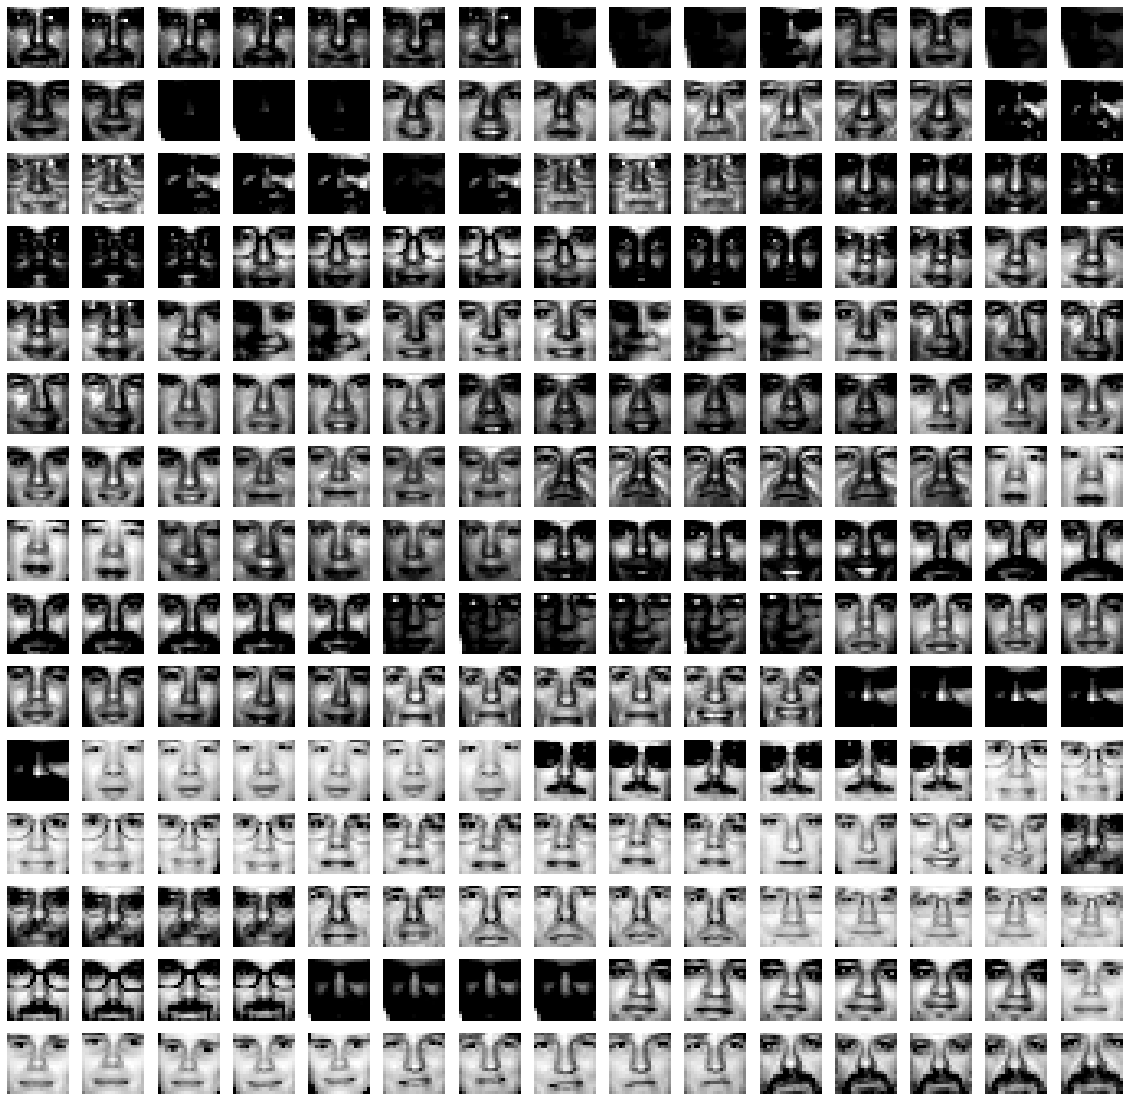

In [25]:
indices = np.random.choice(range(2429), 225)
figure(figsize=(20,20))
for i in range(225):
    subplot(15,15,i+1)
    imshow(np.reshape(V[:,i],(19,19)), cmap='gray')
    axis('off')
show()

In [26]:
def factorize(V):
    lsnmf = nimfa.Lsnmf(V, seed="random_vcol", rank=49, max_iter=50, sub_iter=10,
                        inner_sub_iter=10, beta=0.1, min_residuals=1e-8)
    print("Algorithm: %s\nInitialization: %s\nRank: %d" % (lsnmf, lsnmf.seed, lsnmf.rank))
    fit = lsnmf()
    sparse_w, sparse_h = fit.fit.sparseness()
    print("""Stats:
            - iterations: %d
            - final projected gradients norm: %5.3f
            - Euclidean distance: %5.3f 
            - Sparseness basis: %5.3f, mixture: %5.3f""" % (fit.fit.n_iter,
                                                            fit.distance(),
                                                            fit.distance(metric='euclidean'),
                                                            sparse_w, sparse_h))
    return fit.basis(), fit.coef()

W, _ = factorize(V)
W.shape

Algorithm: lsnmf
Initialization: random_vcol
Rank: 49
Stats:
            - iterations: 50
            - final projected gradients norm: 2.157
            - Euclidean distance: 365.337 
            - Sparseness basis: 0.708, mixture: 0.467


(361, 49)

<Figure size 432x288 with 0 Axes>

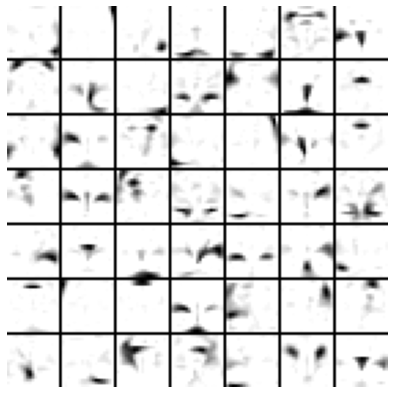

In [27]:
set_cmap('gray')
blank = new("L", (133 + 6, 133 + 6))
for i in range(7):
    for j in range(7):
        basis = np.array(W[:, 7 * i + j])[:, 0].reshape((19, 19))
        basis = basis / np.max(basis) * 255
        basis = 255 - basis
        ima = fromarray(basis)
        ima = ima.rotate(180)
        expand(ima, border=1, fill='black')
        blank.paste(ima.copy(), (j * 19 + j, i * 19 + i))
figure(figsize=(7,7))
imshow(blank)
axis('off')
show()

## 3. Face Recognition using LBPH with `opencv-python`

### Face Recognition

In [13]:
import cv2,os
import numpy as np
from PIL import Image 
import pickle, time
import matplotlib.pylab as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]
print(X.shape, h, w)

y = lfw_people.target
print(np.unique(y))

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print(target_names)

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

faces, ids = [], []
for i in range(X_train.shape[0]):
    faces.append(np.reshape(X_train[i,...], (h,w)))
    ids.append(y_train[i])
ids = np.array(ids)

(1288, 1850) 50 37
[0 1 2 3 4 5 6]
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [8]:
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(faces, ids)
recognizer.save('recognizer_training.yml')

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.77      0.77        13
     Colin Powell       0.98      0.90      0.94        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.92      0.96      0.94       146
Gerhard Schroeder       0.68      0.76      0.72        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.80      0.89      0.84        36

         accuracy                           0.88       322
        macro avg       0.83      0.79      0.80       322
     weighted avg       0.88      0.88      0.87       322

[[ 10   0   1   1   0   1   0]
 [  1  54   1   0   3   1   0]
 [  1   0  18   6   1   0   1]
 [  0   1   1 140   1   0   3]
 [  0   0   1   1  19   0   4]
 [  1   0   0   3   2   9   0]
 [  0   0   0   2   2   0  32]]


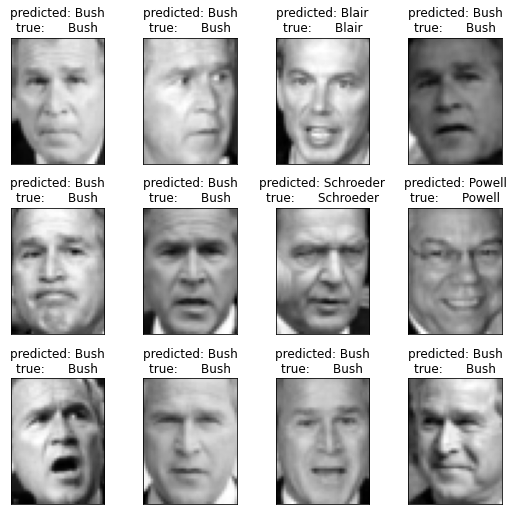

In [14]:
print("Predicting people's names on the test set")
#t0 = time()
y_pred = []
for i in range(X_test.shape[0]):
    pred = recognizer.predict(X_test[i,...].reshape((h,w)))
    y_pred.append(pred[0])

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(len(y_pred))]

plot_gallery(X_test, prediction_titles, h, w)

(190, 265, 3)


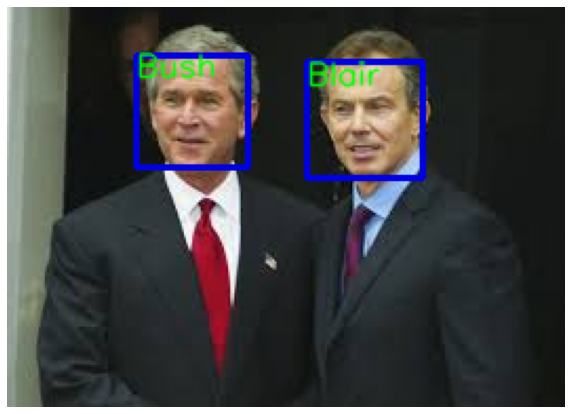

In [17]:
detector = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
im = cv2.imread('images/leaders.jpg')
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(im.shape)
all_faces = detector.detectMultiScale(img, scaleFactor=1.2, minNeighbors=5)
for (x,y,w,h) in all_faces:
    cv2.rectangle(im,(x,y),(x+w,y+h),(225,0,0),2)
    id, conf = recognizer.predict(img[y:y+h,x:x+w])
    cv2.putText(im,str(target_names[id].rsplit(' ', 1)[-1]), 
                (x,y+h//5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) #Draw the text
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.show()

## 4. Face Feature Extraction and Recognition using Gabor Filter Banks

## 4.1 Feature Extraction with Gabor Filter Bank

### with `scikit-image`

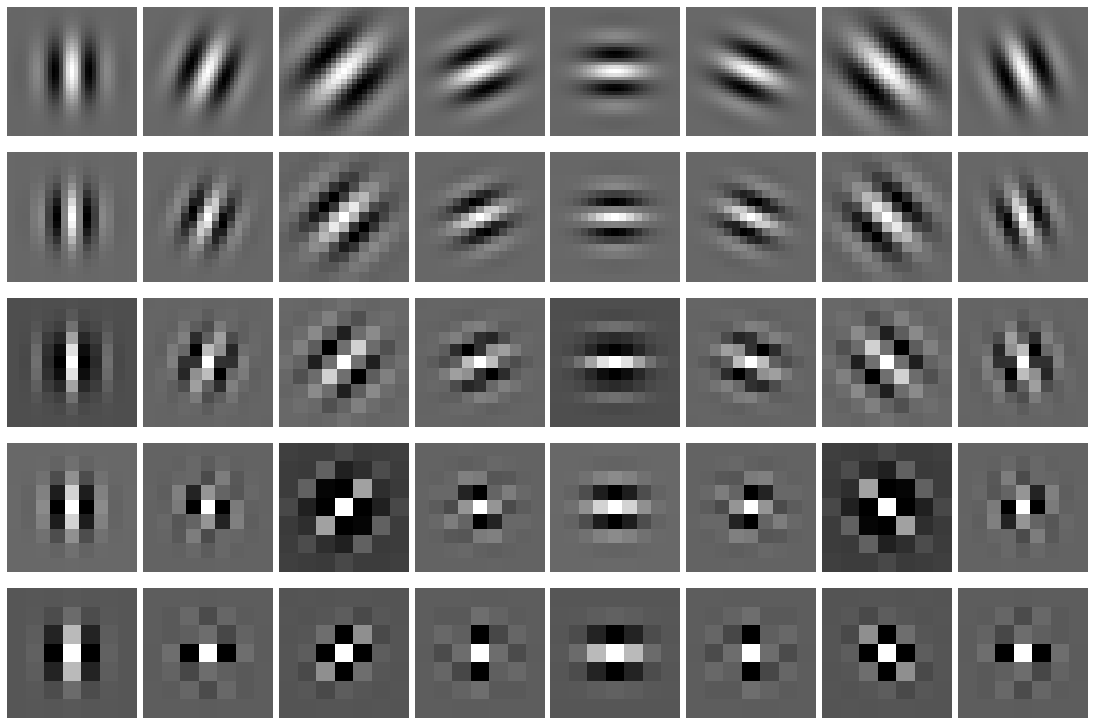

In [466]:
from skimage.filters import gabor_kernel
from scipy.signal import convolve2d

# 5 scales and 8 orientations
def build_filters():
    freqs = []
    filters = []
    for freq in np.arange(0.1,0.6,0.12):
        for theta in np.arange(0, np.pi, np.pi / 8):
            kern = np.real(gabor_kernel(freq, theta=theta))
            filters.append(kern)
    return filters 

filters = build_filters()
plt.figure(figsize=(15,10))
plt.subplots_adjust(0,0,1,1,0.05,0.05)
i = 1
for f in filters:
    plt.subplot(5,8,i), plt.imshow(f), plt.axis('off')
    i += 1
plt.show()

### with `opencv-python`

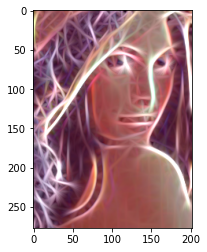

In [413]:
import numpy as np
import cv2
import sys
 
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum
 
img_fn = 'images/lena.jpg'
img = cv2.imread(img_fn)
filters = build_filters()

res = process(img, filters)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

## 4.2 Face Recognition with Gabor Features with `opencv-python` and `scikit-learn`

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob

faces = sorted(glob('images/orl/*_[1-9].jpg'))
len(faces)

90

In [38]:
ksize = 5 #5 #9
kernels = []  #Create empty list to hold all kernels that we will generate in a loop
sigma, gamma = 1, 0.5
for freq in np.arange(0.1,0.6,0.12):
    for theta in np.arange(0, np.pi, np.pi / 8):
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, 1/freq, gamma, 0, ktype=cv2.CV_32F)    #1/freq lamda
        kernels.append(kernel)
X = np.empty((0,2*len(kernels)))
#print(X.shape)
y = []
for imfile in faces:
    im = cv2.imread(imfile, 0)
    label = int(imfile.split('_')[-1][0])
    features = []
    for kernel in kernels:
        #Now filter the image and add values to a new column 
        fim = cv2.filter2D(im, cv2.CV_8UC3, kernel)
        features.append(np.abs(fim).mean()) #fim.mean())
        features.append(np.sum(fim**2)) #fim.var())
    X = np.append(X, np.array([features]), axis=0)
    y.append(label)
X.shape, len(y)

((90, 80), 90)

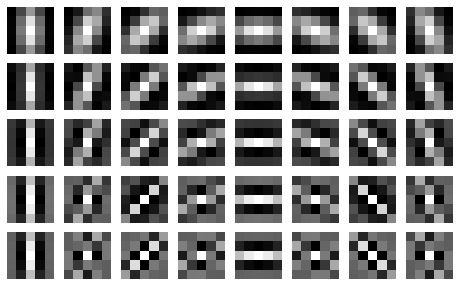

In [40]:
plt.figure(figsize=(8,5))
plt.gray()
for i in range(len(kernels)):
    plt.subplot(5,8,i+1), plt.imshow(kernels[i]), plt.axis('off')
plt.show()

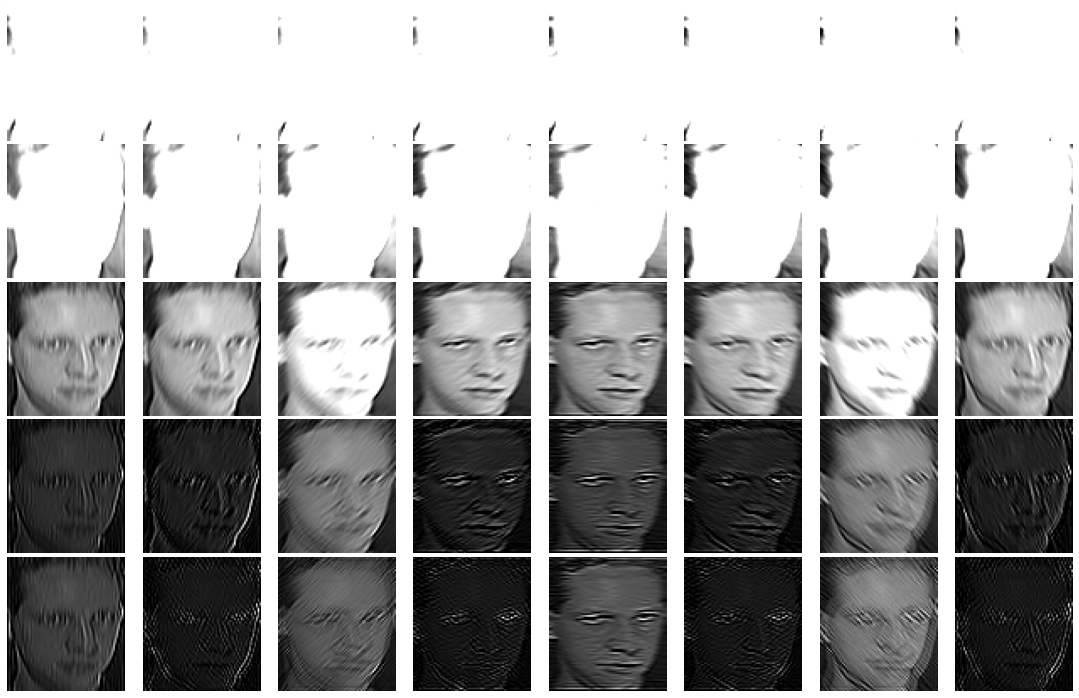

In [41]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(0,0,1,0.95,0.025,0.025)
im = cv2.imread(faces[0], 0)
label = int(imfile.split('_')[-1][0])
i = 0
for kernel in kernels:
    #Now filter the image and add values to a new column 
    fim = cv2.filter2D(im, cv2.CV_8UC3, kernel)
    plt.subplot(5,8,i+1), plt.imshow(fim), plt.axis('off')
    i += 1
plt.show()

### With RandomForest Ensemble Classifier

accuracy: 0.8260869565217391


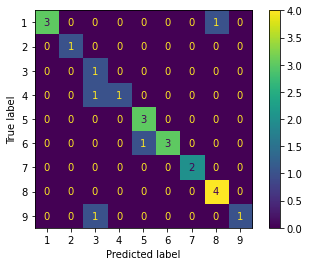

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(y)), test_size=0.25, random_state=1)
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy: {}'.format(sum(y_pred==y_test) / len(y_test)))
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

### With 2-NN Classifier

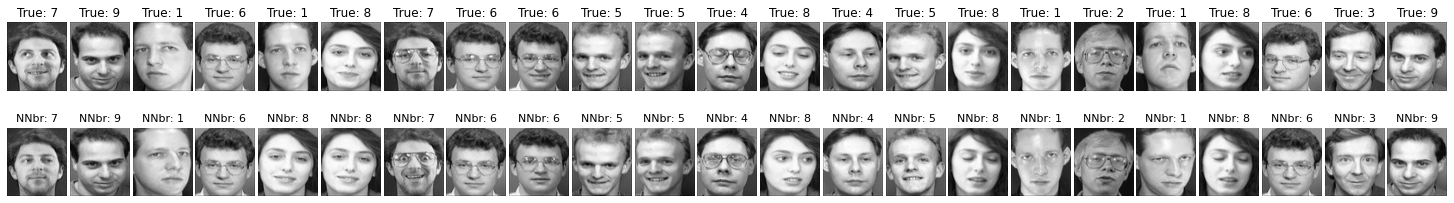

In [8]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
neigh.fit(X_train)
nn_indices = neigh.kneighbors(X_test, 2, return_distance=False)
plt.figure(figsize=(20,3))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
n = len(X_test)
for i in range(n):
    im = cv2.imread(faces[indices_test[i]], 0)
    plt.subplot(2,n,i+1), plt.imshow(im), plt.axis('off'), plt.title('True: {}'.format(y_test[i]), size=12)
    im = cv2.imread(faces[indices_train[nn_indices[i][0]]], 0)
    plt.subplot(2,n,i+n+1), plt.imshow(im), plt.axis('off'), plt.title('NNbr: {}'.format(y[indices_train[nn_indices[i][0]]]), size=11)
plt.show()

## 5. Pedestrian detection with HOG vs HAAR-Cascade features with `opencv-python`

## 5.1 Pedestrian detection with HOG NMS

### Computing BoundingBoxes with HOG-SVM

In [24]:
import numpy as np
import cv2
import matplotlib.pylab as plt
from imutils.object_detection import non_max_suppression

69


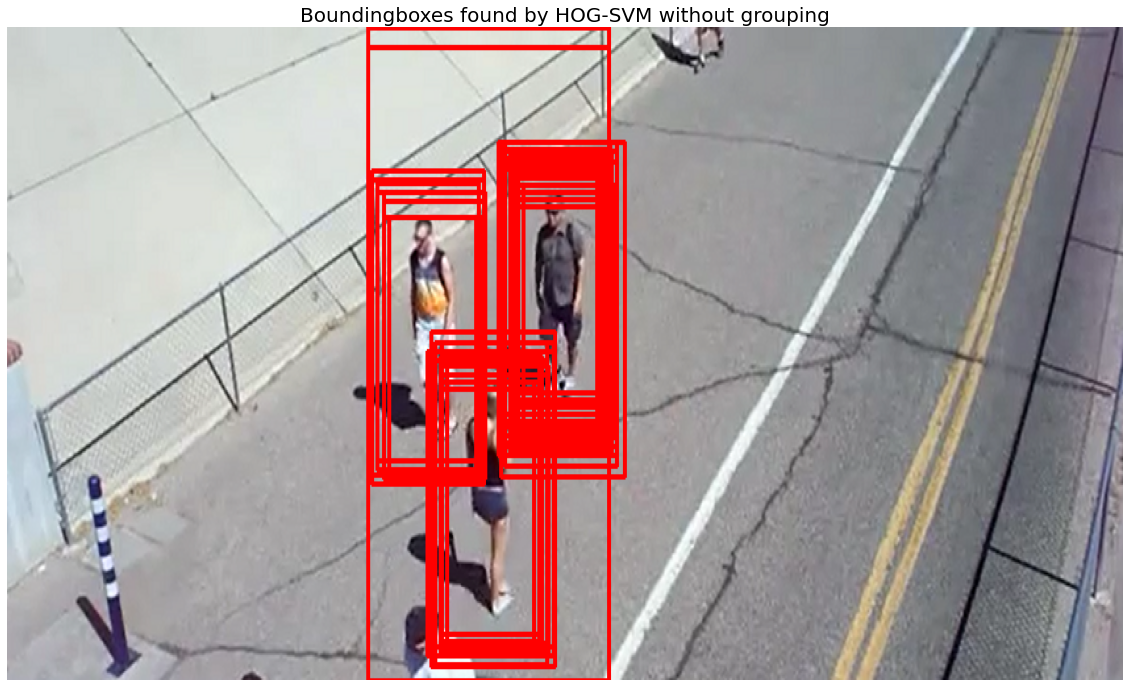

69
3


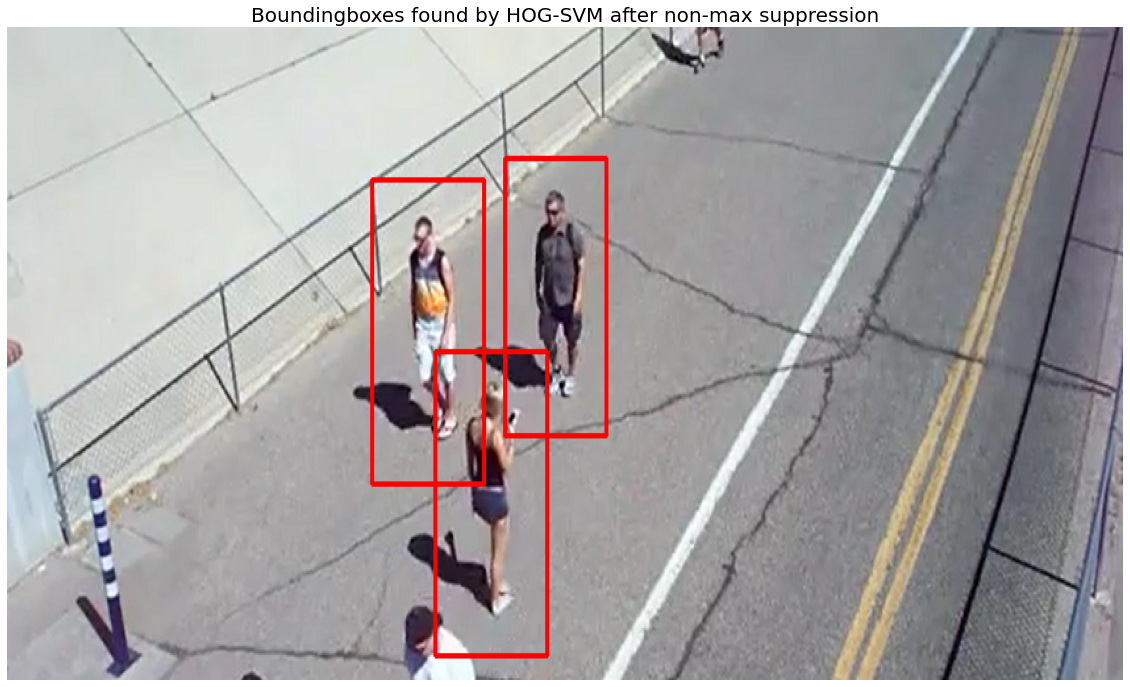

3


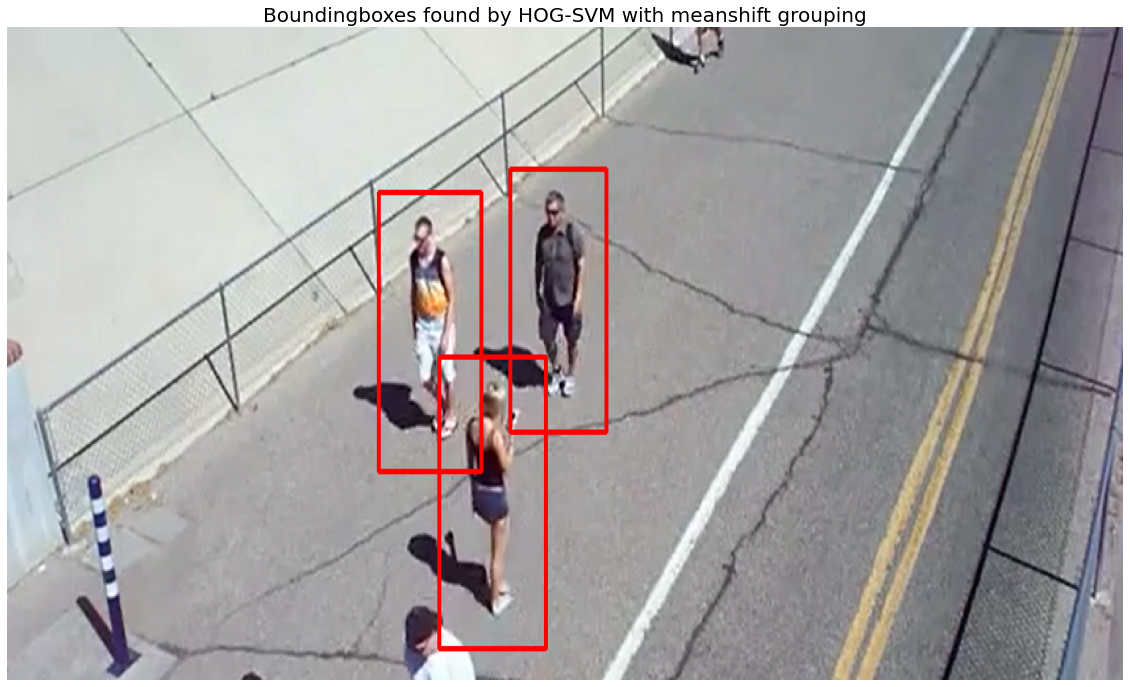

In [27]:
def draw_bounding_boxes(img, found_bounding_boxes, title):
    # copy the original image to draw bounding boxes on it for now, as we'll use it again later
    img_with_raw_bboxes = img.copy()
    for (hx, hy, hw, hh) in found_bounding_boxes:
        cv2.rectangle(img_with_raw_bboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
    plt.figure(figsize=(20, 12))
    img_with_raw_bboxes = cv2.cvtColor(img_with_raw_bboxes, cv2.COLOR_BGR2RGB)
    plt.imshow(img_with_raw_bboxes, aspect='auto'), plt.axis('off')
    plt.title(title, size=20)
    plt.show()

    
img = cv2.imread("images/pedestrians.png")

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(found_bounding_boxes)) # number of boundingboxes
# 69
draw_bounding_boxes(img, found_bounding_boxes, 'Boundingboxes found by HOG-SVM without grouping')

(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(found_bounding_boxes)) # number of boundingboxes
# 69
found_bounding_boxes[:,2] = found_bounding_boxes[:,0] + found_bounding_boxes[:,2]
found_bounding_boxes[:,3] = found_bounding_boxes[:,1] + found_bounding_boxes[:,3]

found_bounding_boxes = non_max_suppression(found_bounding_boxes, probs = weights.ravel(), overlapThresh = 0.2)
found_bounding_boxes[:,2] = found_bounding_boxes[:,2] - found_bounding_boxes[:,0]
found_bounding_boxes[:,3] = found_bounding_boxes[:,3] - found_bounding_boxes[:,1]
print(len(found_bounding_boxes)) # number of boundingboxes
# 3

draw_bounding_boxes(img, found_bounding_boxes, 'Boundingboxes found by HOG-SVM after non-max suppression') 

(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.01, useMeanshiftGrouping=True)
print(len(found_bounding_boxes)) # number of boundingboxes
# 3
draw_bounding_boxes(img, found_bounding_boxes, 'Boundingboxes found by HOG-SVM with meanshift grouping')

## 5.2 HAAR Cascade vs HOG

3
3


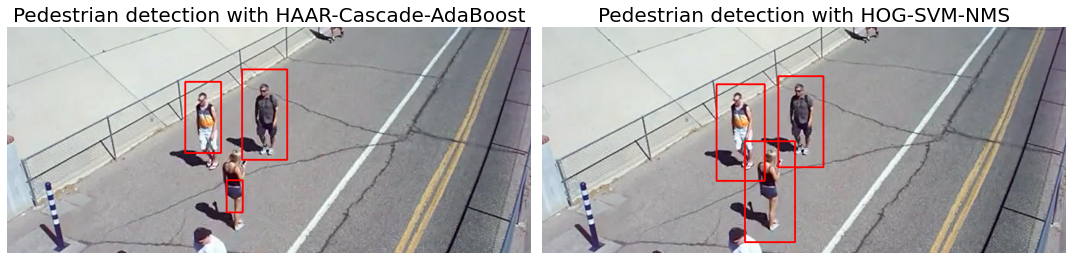

In [29]:
ped_cascade = cv2.CascadeClassifier('models/haarcascade_fullbody.xml')

img = cv2.imread("images/pedestrians.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

peds = ped_cascade.detectMultiScale(gray, 1.01, 3) # scaleFactor=1.2, minNbr=5
print(len(peds)) # number of faces detected
img_haar = img.copy()

(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.01, useMeanshiftGrouping=True)
print(len(found_bounding_boxes)) # number of boundingboxes
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
img_hog = img.copy()
for (hx, hy, hw, hh) in found_bounding_boxes:
    cv2.rectangle(img_hog, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)

for (x,y,w,h) in peds:
    img_haar = cv2.rectangle(img_haar,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(15,7))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_haar, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Pedestrian detection with HAAR-Cascade-AdaBoost', size=20)
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_hog, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Pedestrian detection with HOG-SVM-NMS', size=20)
plt.tight_layout()
plt.show()

## Questions

1. Feature Extraction from **Deep Neual Nets**: The deep neural networks learn hierarchical representations allows them to capture both local and global features. Lower layers tend to focus on local details, while higher layers aggregate information to recognize more complex structures that may span the entire input. 

   Use pretrained models (e.g., `torchvision` models pretrained on `imagenet` dataset) to extract the deep features (embeddings) from the last layer prior to the classification layer. Use the following cats and dogs image to extract the deep features for each of them.

![](images/cats_dogs.png)

   For example, you can use the deep neuralnet **ResNet50** to extract a $2048$ diminseional vector embedding correspondign to each image. Next, use the dimesnsion reduction technique TSNE (feel free to use `scikit-learn.manifold` module's implementation), to reduce the embedding corresponding to each images to 2 dimension and use scatterplot to visualize the images. Overlay the images on top, corresponding to their reduced 2D coordinates. 
   
   You should obtain a figure like the following one, the cats and dogs are clearly separated even in the low dimensional embedding, as can be seen:
   
![](images/cat_dog_resnet50_out.png)

2. Semantic Image **Search Engine**: Use deep image features to search similar images. Download the Kaggle fast food dataset from here: https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset. The following figure shows a few sample images from the dataset (you may want to reduce the dataset, e.g., create a small dataset with 25 pizzas, burgers and sandwiches, selected randomly, to start with).

![](images/pizza_burger_sandwich.png)

Use a pretrained neural net (e.g., **EfficientNet**) to obtain the embeddings for the images and use a nearest-neighbor algorithm (e.g., `ball_tree` from `sklearn.neighbors.NearestNeighbors`) to find the nearest embeddings from the search images and display the top `k` (e.g., `k=5`) **similar images** found, as shown in the next figure (along with the NN-distance: lower the distance, higher the similarity).

![](images/semantic_search.png)

You can use the above implementation to recommend similar food items to customers. Also, you can see from the above figure, all but the last image are burger images. the last image returned is wrong, it's not a burger. Fine-tune the pretrained model on the training dataset to improve the accuracy of the model, test the accuracy (e.g., with Precision-5 metric) on held-out test dataset.


## References

1. https://www.youtube.com/watch?v=8_P257eFEqA
2. https://www.youtube.com/watch?v=ROgT1XDTX4Q
3. https://www.youtube.com/watch?v=kl6-NHxcn-k
4. https://www.youtube.com/watch?v=qRouVgXb1G4
5. https://www.youtube.com/watch?v=J5-xQJjn82s
6. https://www.youtube.com/watch?v=2qUIz-MCKX0
7. https://openaccess.thecvf.com/content_CVPR_2019/papers/Barath_MAGSAC_Marginalizing_Sample_Consensus_CVPR_2019_paper.pdf